<p float="left">
    <img src="images/1200px-Flag_of_the_United_Kingdom.svg.png" width="460" height="400"/>
    <img src="images/led-zeppelin.jpeg" width="330" height="370"/>
</p>

<img src="images/led-zeppelin.jpeg" width="330" height="370"/>


# "Anything British"


When asked what type of music I enjoy, I typically respond, "anything British." I am not an English native, have not spent any significant amount of time in the UK, nor do I have any other rational or emotional justification to prefer any aspect of the culture. However, my personal experience suggests the distribution of phenomenal musicians is heavily skewed British. From classic like the Beatles, the Rolling Stones, Led Zeppelin, and Pink Floyd to modern virtuosos like Muse, Coldplay, and Adele, the country of 60M people's trade surplus of rhythm is seemingly unmatched.

As an objectivist, I am also acutely aware that many biases could be skewing my observations, to name a few:

1. **Genre -** The aforementioned British artist are mostly rock & roll; the trend may be localized to this genre.
2. **Language -** As an American, it's more likely I'd listen to music in my native language of english.
3. **Distribution -** Historically strong trading relations between the US and England may have attributed to a greater awareness of British music.
4. **Stylistic -** My musical preferences happen to skew British, and I've developed a bias through reinforcing this proclivity. 

The genesis for this project was twofold: to test a hypothesis about British musical talent and to learn more about the GCP Custom Search Engine microservice.

### I. Business Problem: 

Data Science is fundamentally about finding signals in the noise. Those signals are the statistically significant patterns that characterize the dataset. If the data are representative, the hope is to create & apply knowledge from the observed systemic relationships to make generalized predictions and improvements. Less formally, we can use data science techniques to get at the general thrust of phenomena - which I submit is a proxy for truth. 

Although this project was not designed to solve a specific business problem, the concepts can be applied to a spectrum of investment decisions where understanding a market segment is critical for success. For example, a thesis tailored for the music industry:

>***If launching a new record label, is it possible to mitigate risk by focusing in certain geographic regions, i.e. - do some countries have an ecosystem, educational infrastructure, or audio-centric culture that inspires and develops musicians better than others?***

<center>
<img src="./images/EU-Music.jpeg" width=400 height=300/>
</center>

**The Art of Data Science -**

The first major question is how to quantify a subjective concept of "best" in the realm of art. It's tempting to use mathematically convenient numbers from record sales volume, touring revenue, and streams, but these do not account for relative population sizes, marketing budges, native languages, and Spotify market penetration. 

**Experiment Design -**

My answer was approached by the following thought experiment: if **Country X** exhibited a tendency towards producing better musicians, then we would observe a correspondingly higher likelihood of listeners from around the globe outside **Country X** streaming its music. This concept mathematically translates to Bayes' Theorem, and his powerful idea is the tool of choice for cutting through statistical noise. 

----------

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

## GCP & Spacy
from googleapiclient.discovery import build
import spacy

## utilities
import time
import sys
import pyprind
from tqdm import tqdm
tqdm.pandas(desc = 'prog_bar')
import warnings
warnings.filterwarnings("ignore")

## plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## custom modules
sys.path.append('./code/')
sys.path.append('./images/')
from utils import map_uniq

In [2]:
## environment settings
nlp = spacy.load('en_core_web_md')

plt.style.use('ggplot')
pd.set_options = {
'precision'           : 2,
'display.max_columns' : 30,
'display.width'       : 1000,
}

### II. Data Sourcing & Wrangling -

Import original Spotify csv file containing the **Top 200** tracks by day across the world.
> URL: https://mkt.tableau.com/Public/Datasets/Spotify_Daily_Streaming.csv.zip

**2.1 - Data Dictionary:**

1. Date - calendar date of record.
2. Track URL - link to location of Spotify `Track Name`
3. Position - `Track Name` rank (1 to 200) for total `Streams` on `Date`
4. Track Name - title of track
5. Artist - `Track Name` recording artist
6. Streams - total `Track Name` streams in `Country` on `Date`
7. Country - geograpic location of listeners

In [3]:
## specify filepath and load data
path = './data/Spotify_Daily_Streaming.csv'
df = pd.read_csv(path)

## datetime conversions
dates = pd.to_datetime(df['Date'].astype(str), format='%m/%d/%Y')
df.drop(columns = 'Date', inplace = True)
df.insert(0, 'Date', dates)

## print size & show preview
print('size:', df.shape[0])
df.head()

size: 8469130


,Date,Track URL,Position,Track Name,Artist,Streams,Country
0,2017-07-20,https://open.spotify.com/track/3RXkboS74UYzN14...,1,NaN,NaN,3457,Lithuania
1,2018-07-31,https://open.spotify.com/track/77wz2VtAwxAwYOG...,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,238729,Netherlands
2,2018-08-02,https://open.spotify.com/track/77wz2VtAwxAwYOG...,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,245639,Netherlands
3,2017-07-23,https://open.spotify.com/track/6mw02h3qbWmuq2b...,1,Millionär,187 Strassenbande,387632,Germany
4,2018-06-29,https://open.spotify.com/track/2iUXsYOEPhVqEBw...,1,Youngblood,5 Seconds of Summer,261795,Australia


-------

### III. Exploratory Data Analysis -

Our initial EDA uncovers a dataset of ~ 8.5M records, 7 columns, and missing values.

In [4]:
## check series data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469130 entries, 0 to 8469129
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date        datetime64[ns]
 1   Track URL   object        
 2   Position    int64         
 3   Track Name  object        
 4   Artist      object        
 5   Streams     int64         
 6   Country     object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 452.3+ MB


In [5]:
## check NA values
df.isna().any()

Date          False
Track URL      True
Position      False
Track Name     True
Artist         True
Streams       False
Country       False
dtype: bool

In [6]:
## explore NA values
df.loc[df['Artist'].isna()]

,Date,Track URL,Position,Track Name,Artist,Streams,Country
0,2017-07-20,https://open.spotify.com/track/3RXkboS74UYzN14...,1,NaN,NaN,3457,Lithuania
6522,2017-07-20,https://open.spotify.com/track/4JAyIDXOqNM6qHu...,10,NaN,NaN,52358,Indonesia
10556,2017-12-31,https://open.spotify.com/track/5cjecvX0CmC9gK0...,102,NaN,NaN,103170,Germany
16731,2018-03-17,https://open.spotify.com/track/0JN8LCqXsqyeedS...,101,NaN,NaN,2110,Viet Name
16732,2018-02-04,https://open.spotify.com/track/5rbXOUQCaYcSnW5...,101,NaN,NaN,53446,Germany
...,...,...,...,...,...,...,...
8447627,2017-12-20,https://open.spotify.com/track/0ocIyziRJhnicqG...,190,NaN,NaN,3892,Switzerland
8448773,2018-02-06,https://open.spotify.com/track/0ocIyziRJhnicqG...,192,NaN,NaN,34796,Germany
8448774,2018-01-05,https://open.spotify.com/track/5fBLHMccZTRyCxF...,192,NaN,NaN,39109,Germany
8467004,2018-04-05,https://open.spotify.com/track/4kaOjoMZnc6FzPC...,81,NaN,NaN,1582,Viet Name


##### **3.1 - Data Drop Justifications:**

* Artist names are essential for the project, however missing values only account for 0.02% of the data. 

* The missing values are distributed across 53 of the 63 countries in our dataset, making them roughly representative for an initial EDA.

* Track URLs are not useful and are dropped as well.

In [7]:
print(f"Percentage of missing values: {100*df.loc[df['Artist'].isna()].shape[0]/df.shape[0]:0.4g}%")
print('Countries with missing artist data:', len(df.loc[df['Artist'].isna()]['Country'].unique()))
print('Total countries in dataset:', df.Country.unique().shape[0])

Percentage of missing values: 0.0327%
Countries with missing artist data: 53
Total countries in dataset: 63


In [8]:
## drop missing values
df2 = df.dropna()
## drop track urls
df2.drop(columns = 'Track URL', inplace = True)
df2.head(3)

,Date,Position,Track Name,Artist,Streams,Country
1,2018-07-31,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,238729,Netherlands
2,2018-08-02,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,245639,Netherlands
3,2017-07-23,1,Millionär,187 Strassenbande,387632,Germany


##### **3.2 - Determine date range:**

Dataset spans 2.5 years, from `2017-01-01` to `2019-07-01`.

In [9]:
df2.sort_values(by = 'Date', inplace = True)
print(df2.iloc[0]['Date'])
print(df2.iloc[-1]['Date'])

2017-01-01 00:00:00
2019-07-01 00:00:00


<p>&nbsp</p>  

##### **3.3 - Unique artists & tracks:**

The dataset has 11,046 unique artists responsible for a total of 40,280 unique tracks. `Ed Sheeran`, the top artist, who wrote `Shape of You`, the top track, happens to be British - good start!

In [10]:
df2.Artist.describe()

count        8466353
unique         11046
top       Ed Sheeran
freq          215590
Name: Artist, dtype: object

In [11]:
df2['Track Name'].describe()

count          8466353
unique           40280
top       Shape of You
freq             43596
Name: Track Name, dtype: object

<p>&nbsp</p>  

##### **3.4 - Top US Artists:**

Visualize top artists in the United States by total streams.

In [12]:
## filter by country, groupby artist, and total streams
us_streams = df2.loc[df2.Country == 'United States']\
                .groupby('Artist', as_index = False)['Streams'].sum()\
                .sort_values('Streams', ascending = False)\
                .reset_index(drop = True)

us_streams.head()

,Artist,Streams
0,Post Malone,4072547100
1,Drake,3394541388
2,XXXTENTACION,2764151089
3,Khalid,1745765825
4,Kendrick Lamar,1732202348


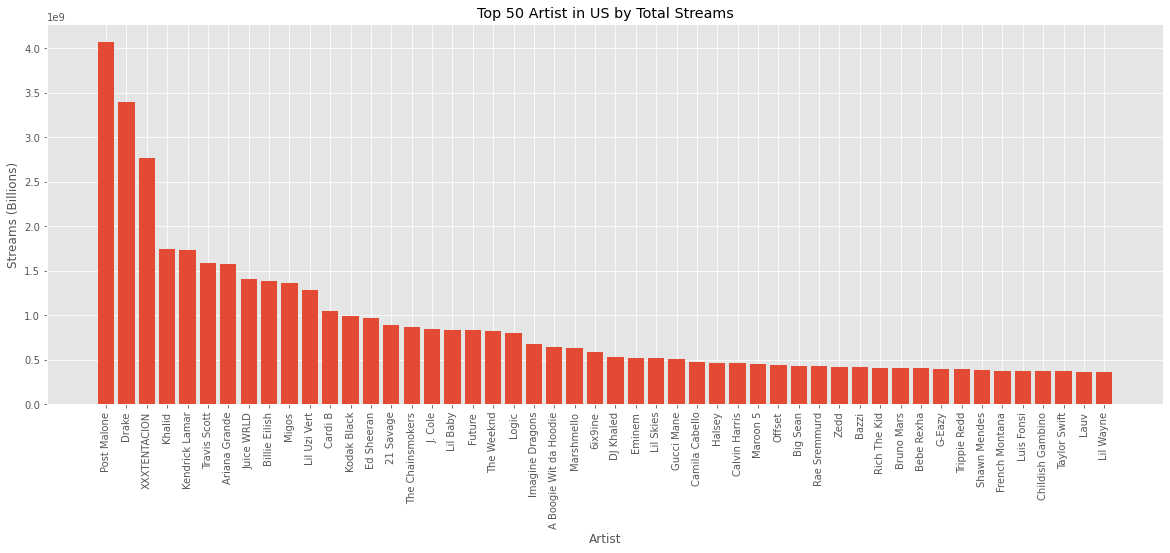

In [13]:
## slice df by top 50 artists
str_data = us_streams.iloc[:50,:]

plt.figure(figsize = (20, 7))
plt.title('Top 50 Artist in US by Total Streams')
plt.bar(str_data.Artist, str_data.Streams)

plt.xticks(rotation='vertical')
plt.xlabel('Artist')
plt.ylabel('Streams (Billions)');

In [14]:
## calc total streams
tot_str = us_streams.Streams.sum()

## total songs for OTHER - artists not in top 50
tot_oth = us_streams.iloc[20:,:].Streams.sum()

## define dataframe for pie visualization
pie_data = str_data.drop(str_data.tail(30).index)

## manually add Other row to other_data
pie_data.loc[len(pie_data)]=['OTHER', tot_oth]

pie_data.head()

,Artist,Streams
0,Post Malone,4072547100
1,Drake,3394541388
2,XXXTENTACION,2764151089
3,Khalid,1745765825
4,Kendrick Lamar,1732202348


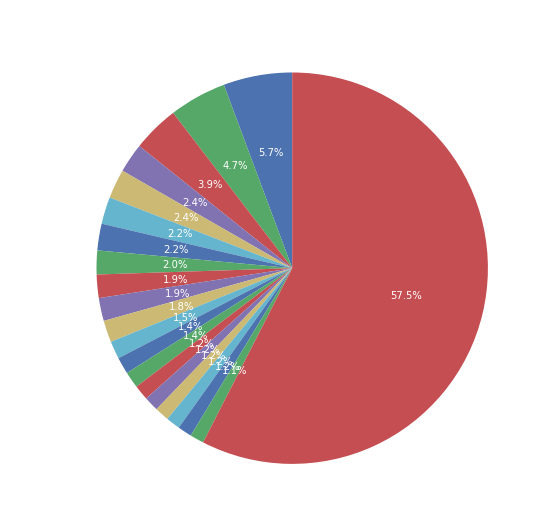

In [15]:
plt.style.use('seaborn-deep')

fig, ax1 = plt.subplots(figsize=(9, 9), subplot_kw = dict(aspect = 'equal'))

_, _, autotexts = ax1.pie(pie_data.Streams,
                          labels = pie_data.Artist.tolist(),
                          autopct = '%1.1f%%',
                          shadow = False, 
                          startangle = 90,
                          textprops = dict(color = "w"))
## set title
ax1.set_title('Percentage of Tracks Streamed from Top 20 Artists', color = 'w')
## set transparent background
fig.set_facecolor('none')
plt.show();

##### **3.5 - Most Prolific US Artists:**

Visualize most prolific artists in the United States by unique tracks in the top 200.

In [16]:
hits = df2.loc[df2.Country == 'United States']\
          .groupby('Artist')['Track Name'].unique()\
          .apply(lambda x: len(x))\
          .rename('hit_tracks')\
          .reset_index()

## sort by unique # tracks
hits = hits.sort_values('hit_tracks', ascending = False).reset_index(drop = True)
hits.head()

,Artist,hit_tracks
0,Future,106
1,Drake,76
2,Logic,61
3,XXXTENTACION,58
4,Migos,41


Plot top 50 most prolific artists - 

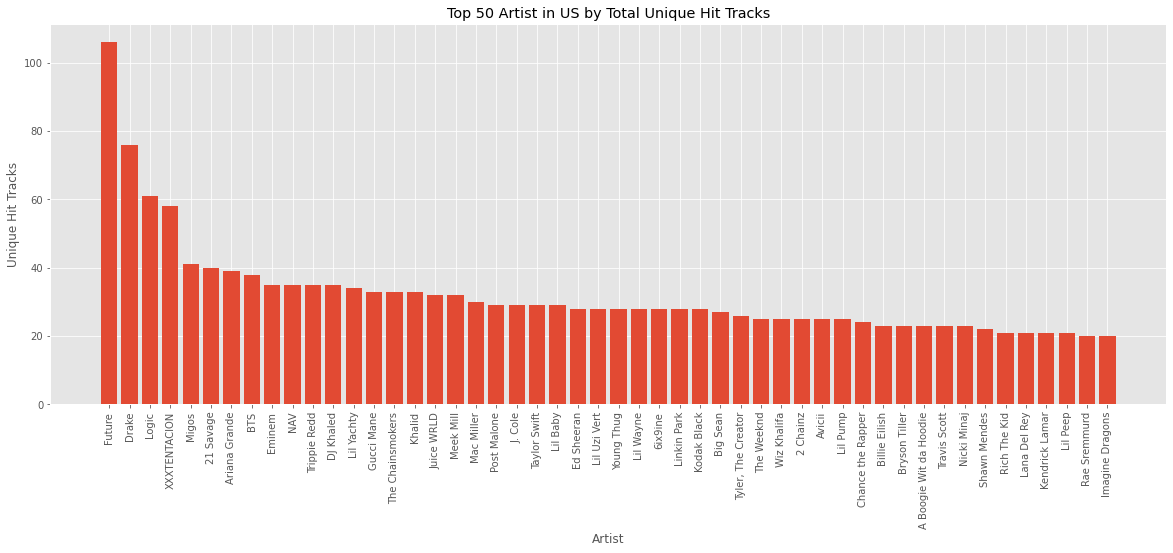

In [18]:
## reset style
plt.style.use('ggplot')
## slice top 50
tmp_hits = hits.iloc[:50,:]
## setup plot
plt.figure(figsize = (20, 7))
plt.title('Top 50 Artist in US by Total Unique Hit Tracks')
plt.bar(tmp_hits.Artist, tmp_hits.hit_tracks)
## format plot
plt.xlabel('Artist')
plt.ylabel('Unique Hit Tracks')
plt.xticks(rotation='vertical');

<p>&nbsp</p>  

##### **3.6 - One Hit Wonders?**

To explore the relationship between total artist streams and unique tracks in the top 200, we first join `hit_tracks` to `us_streams`.

In [19]:
## join hit_tracks to us_streams
df_stats = pd.merge(us_streams, hits, how = 'left')
df_stats.head()

,Artist,Streams,hit_tracks
0,Post Malone,4072547100,29
1,Drake,3394541388,76
2,XXXTENTACION,2764151089,58
3,Khalid,1745765825,33
4,Kendrick Lamar,1732202348,21


Calculating the correlation coefficient between `hit_tracks` and `Streams` yields **68.48%**, suggesting a strong positive correlation.


In [20]:
cor = df_stats.Streams.corr(df_stats.hit_tracks)
print(f'Correlation between number of unique tracks and total streams:{100*cor: 0.5g}%')

Correlation between number of unique tracks and total streams: 68.48%


<p>&nbsp</p>  

##### **3.7 - Openers & Headliners**

Our dataset is substantially left-skewed with respect to artist streams. To better understand their respective popularity, clustering algorithms are applied to group the artists in one dimension by streams.

In [21]:
## create a dataframe from listener streams with y dimension = 0
data = pd.DataFrame(us_streams.Streams)
data['y'] = int(0)
data.head()

,Streams,y
0,4072547100,0
1,3394541388,0
2,2764151089,0
3,1745765825,0
4,1732202348,0


**Elbow Method** for cluster count determination.

* The chart shows SSE changes substantially and flattens at clusters = 4.

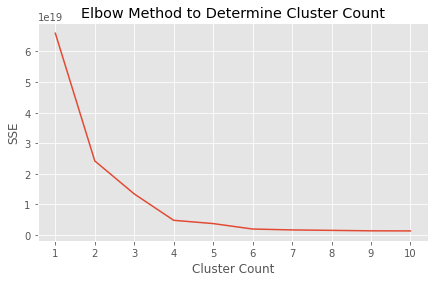

In [22]:
## confirm cluster count
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 24,
}

## list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data.iloc[:, :2])
    sse.append(kmeans.inertia_)
    
## plot SSEs
plt.figure(figsize = (7, 4))
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Method to Determine Cluster Count')
plt.xlabel('Cluster Count')
plt.ylabel('SSE')
plt.show();

<p>&nbsp</p>  

**Silhouette Score Method** for cluster count determination.

* The Silhouette Score (S2) plot is monotonically decreasing, so there is no readily apparent global optimum. Our knowledge about the dataset's dispersion with respect to streams drives us away from the conclusion that 2 clusters are optimal. Further, the difference between 3 and 4 clusters appears immaterial, while the S2 drops significantly after clusters = 4. Given 4 is the optimal cluster count deduced from the SSE test, we can conclude that the S2 method supports the previous test.

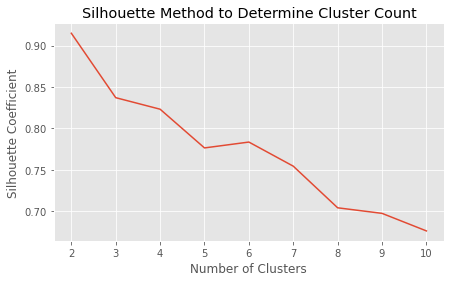

In [23]:
from sklearn.metrics import silhouette_score

## holds the silhouette coefficients for each k
silhouette_coefficients = []

## iterate over candidate cluster values
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data.iloc[:, :2])
    score = silhouette_score(data.iloc[:, :2], kmeans.labels_)
    silhouette_coefficients.append(score)

## visualize results
plt.figure(figsize = (7, 4))
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Method to Determine Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

**Fit data** with 4 clusters:

In [24]:
kmeans = KMeans(
    init = 'random',
    n_clusters = 4,
    n_init = 10,
    max_iter = 300,
    random_state = 42
)

## fit data and add results to dataframe
kmeans.fit(data)
data['cluster'] = kmeans.labels_

## modify cluster keys for ordinal consistency, i.e., cluster_0 streams < cluster_3 streams:
## create mapping dict
cluster_map = {0 : 2,
               1 : 1, 
               2 : 0, 
               3 : 3}
## create a new column by applying a mapping dict to clusters
data['cluster_2'] = data.cluster.apply(lambda x: cluster_map[x])
data.head()

,Streams,y,cluster,cluster_2
0,4072547100,0,3,3
1,3394541388,0,3,3
2,2764151089,0,3,3
3,1745765825,0,0,2
4,1732202348,0,0,2


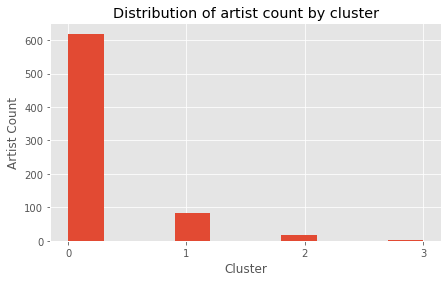

In [25]:
plt.figure(figsize = (7, 4))
plt.title('Distribution of artist count by cluster')
plt.hist(data.cluster_2)
plt.xticks(list(set(data.cluster_2)))
plt.ylabel('Artist Count')
plt.xlabel('Cluster');

<p>&nbsp</p>  

**Visualize Clusters:**

* Our cluster plot shows a clear distinction between the 4 groups, characterized by their dispersion:
1. Cluster 0 - the largest group is highly concentrated with total streams under 200M.
2. Cluster 1 - the second largest group starts to exhibit to separation, with streams in the 200-700M range.
3. Cluster 2 - the first cluster where all artists are nearly distinguishable. 18 total artists had stream counts from 750M to 1.75B.
4. Cluster 3 - far away from all clusters and showing the highest internal variation, these 3 artists streamed from 2.75 to over 4B.

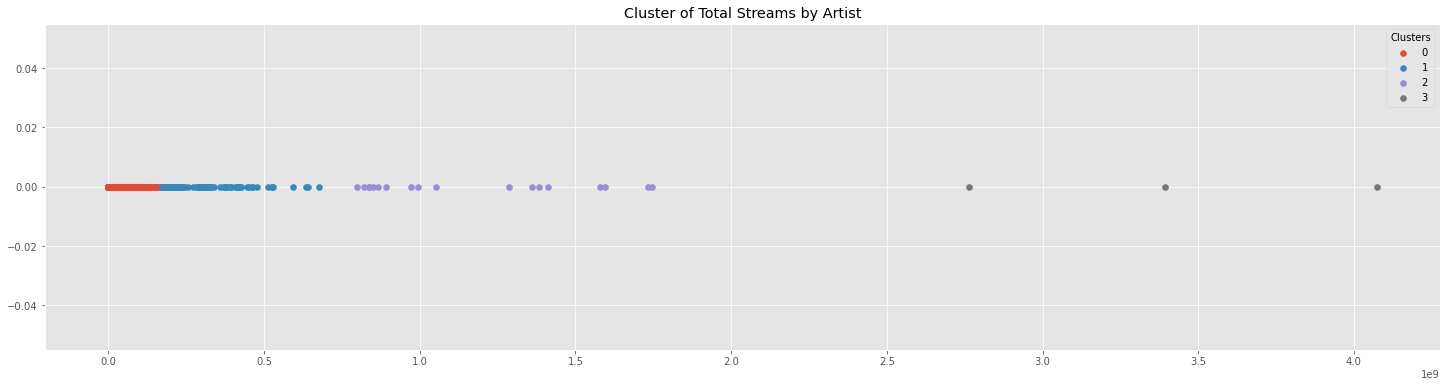

In [26]:
n_clusters = 4

cmap = plt.cm.get_cmap('Spectral')
plt.figure(figsize = (25, 6))
plt.title('Cluster of Total Streams by Artist')

for i, cluster in data.groupby('cluster_2'):
    _ = plt.scatter(cluster.Streams, 
                    cluster.y, 
                    label = i)
    
plt.legend(title = 'Clusters');

<p>&nbsp</p> 

##### **3.7 - Who's the Greatest?**

We'll wrap up our EDA by answering a defining question: *Beatles or the Rolling Stones?*

<p float="left">
    <img src="./images/Beatles_ad_1965_just_the_beatles_crop.jpeg" width=368 height=400/>
    <img src="./images/stones-goats-head-soup-aubrey-powell.jpeg" width=400 height=400/>
</p>

##### **Answer:**

* With over 5x the streams during the same period, the unequivocal answer according to Spotify users in this dataset is the Beatles. 
* An additional find worth noting - the Beatles largest fan base is the UK, who prefer the Fab Four 20:1 over the Stones. 
* Americans are the Rolling Stones' biggest audience, but preferences in the US are effectively equivalent between the two bands. 
* The Beatles have fans in over 22 different countries, whereas the Rolling Stones only made the top Top 200 daily tracks in 8 unique countries.

In [27]:
## build df for the beatles
beatles = df2.loc[(df2.Artist == 'The Beatles')]\
             .groupby('Country', as_index = False)['Streams'].sum()\
             .sort_values('Streams', ascending = False)\
             .reset_index(drop = True)

print(f'Global streams for The Beatles: {beatles.Streams.sum():,}\n')
#beatles.to_csv('./output/beatles.csv')
beatles.head()

Global streams for The Beatles: 5,031,940



,Country,Streams
0,United Kingdom,1924526
1,Global,626247
2,Israel,586879
3,United States,556579
4,Czech Republic,363084


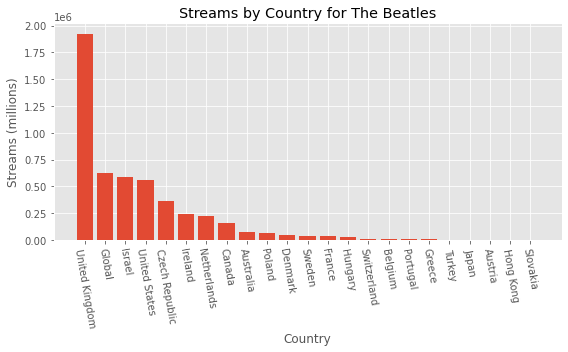

In [28]:
plt.figure(figsize = (8, 5))
plt.title('Streams by Country for The Beatles')
plt.bar(beatles.Country, beatles.Streams)
plt.xticks(rotation=-80)
plt.xlabel('Country')
plt.ylabel('Streams (millions)')
plt.tight_layout();

In [29]:
## build df for the rolling stones
stones = df2.loc[(df2.Artist == 'The Rolling Stones')]\
            .groupby('Country', as_index = False)['Streams'].sum()\
            .sort_values('Streams', ascending = False)\
            .reset_index(drop = True)

print(f'Global streams for The Rolling Stones: {stones.Streams.sum():,}\n')
#stones.to_csv('./output/stones.csv')
stones.head()

Global streams for The Rolling Stones: 886,356



,Country,Streams
0,United States,549033
1,United Kingdom,108457
2,Ireland,101447
3,Canada,63463
4,Czech Republic,27561


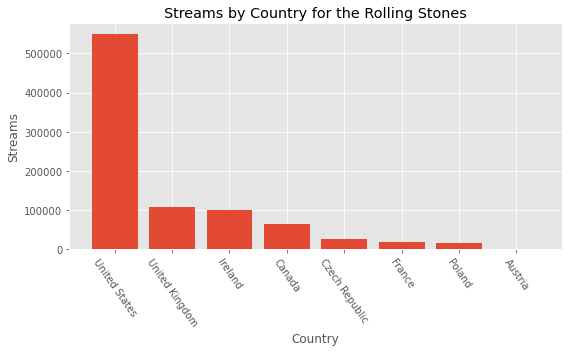

In [30]:
plt.figure(figsize = (8, 5))
plt.title('Streams by Country for the Rolling Stones')
plt.bar(stones.Country, stones.Streams)
plt.xlabel('Country')
plt.ylabel('Streams')
plt.xticks(rotation=-55)
plt.tight_layout();

A direct comparision of listener streams favors the Beatles in every country where both artist had tracks in the Top 200. 

In [31]:
## inner join for direct comparison by country
beatles_stones = pd.merge(left = beatles, 
                          right = stones, 
                          on = 'Country',
                          suffixes = ("_Beatles", "_Stones"))
beatles_stones

,Country,Streams_Beatles,Streams_Stones
0,United Kingdom,1924526,108457
1,United States,556579,549033
2,Czech Republic,363084,27561
3,Ireland,239161,101447
4,Canada,156508,63463
5,Poland,69955,15574
6,France,36787,18864
7,Austria,4059,1957


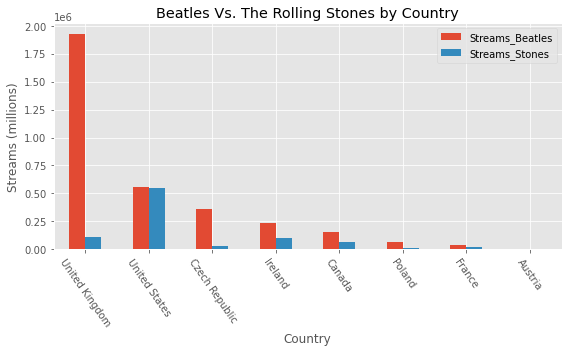

In [32]:
beatles_stones.plot(kind = 'bar', 
                    x = 'Country',
                    figsize = (8, 5),
                    rot = -55,
                    ylabel = 'Streams (millions)',
                    title = 'Beatles Vs. The Rolling Stones by Country')
plt.tight_layout();

------------

<img src='./images/Radiohead.jpeg' width = 350 height = 300/>

### IV. Feature Engineering -

The `Country` in this dataset refers to the streaming listener's location vice the artist origin. In order to compare artists by national origin, it follows that we must first source this information. 

We know from EDA there are 11,046 unique artists, so if we were to manually research the artist nationalities, at a gather rate of 2 per minute the research task would require 92 hours of Googling...

To solve this problem, I designed a system to automate the process that combines **Google Cloud Platform's Custom Search Engine API** and **Natural Language Processing** to parse the results with **spaCy**. 

Although my programmatic solution is more efficient than manual research, it is not inherently effective - and efficacy is imperative when working with 8.5M records: at \\$0.005 per API call, looping over every row of our dataset would generate a \\$40,612.37 bill. However, the simple procedure below kept my cloud costs to a digestible \\$52.78

***\>> Warning: if you clone this repo, do the math before you run the code.*** 

To minimize API calls, we employ the following procedure:

1. Create a dictionary of unique artists in our dataset
2. Use the Google CSE + Spacy NLP process to determine each artist's nationality 
3. Map the nationalities back to each dataframe record

<br>

![process](./images/brp-process.jpeg)

<p>&nbsp</p>  

##### **4.1 - Setup GCP Custom Search Engine (CSE) API:**

To use GCP's Custom Search API, you'll first need to set up a [Programmable Search Engine](https://programmablesearchengine.google.com/). The CSE for this project was configured to search only [Wikipedia](https://en.wikipedia.org/wiki), ignore images, limit region to the US, and return only results in the English language.

In [33]:
## API key
my_api_key = 'API_KEY'
## search engine ID
my_cse_id = '1234567890'
## public url
p_url = 'https://cse.google.com/cse?cx=1234567890'
## base_url
base_url = 'https://customsearch.googleapis.com/customsearch/v1'

## define search function
def google_search(search_term, api_key, cse_id, **kwargs):
    service = build('customsearch', 'v1', developerKey = api_key)
    res = service.cse().list(q = search_term, cx = cse_id, **kwargs).execute()
    return res['items']

<p>&nbsp</p>  

##### **4.2 - Test CSE Function:**

Run CSE function for "led zeppelin" and return 10 results. 

<img src='./images/zep-2.jpeg' width = 420 height = 300/>


In [34]:
results = google_search('led zeppelin', my_api_key, my_cse_id, num = 10)
results[0]

{'kind': 'customsearch#result',
 'title': 'Led Zeppelin - Wikipedia',
 'htmlTitle': '<b>Led Zeppelin</b> - Wikipedia',
 'link': 'https://en.wikipedia.org/wiki/Led_Zeppelin',
 'displayLink': 'en.wikipedia.org',
 'snippet': 'Led Zeppelin were an English rock band formed in London in 1968. The group consisted of vocalist Robert Plant, guitarist Jimmy Page, bassist/keyboardist\xa0...',
 'htmlSnippet': '<b>Led Zeppelin</b> were an English rock band formed in London in 1968. The group consisted of vocalist Robert Plant, guitarist Jimmy Page, bassist/keyboardist&nbsp;...',
 'cacheId': 'D8whGx2GbfgJ',
 'formattedUrl': 'https://en.wikipedia.org/wiki/Led_Zeppelin',
 'htmlFormattedUrl': 'https://en.wikipedia.org/wiki/<b>Led</b>_<b>Zeppelin</b>',
 'pagemap': {'hcard': [{'url_text': 'ledzeppelin.com',
    'fn': 'Led Zeppelin',
    'url': 'ledzeppelin.com'},
   {'fn': 'Led Zeppelin'},
   {'fn': 'Led Zeppelin songs'},
   {'fn': 'Robert Plant'},
   {'fn': 'Jimmy Page'},
   {'fn': 'John Paul Jones'},
 

After testing, we find that the `snippet` key is the most useful result.

In [35]:
results[0]['snippet']

'Led Zeppelin were an English rock band formed in London in 1968. The group consisted of vocalist Robert Plant, guitarist Jimmy Page, bassist/keyboardist\xa0...'

<p>&nbsp</p>  

##### **4.3 - Natural Language Processing Test:**

In order to determine how to find what we want to find (ensure our design will work as planned before incurring cloud costs) we perform a second test by applying spacy's Named Entity Recognition (NER) feature to the results. 
<br><br>
The type of entity is extracted with the `.label_` attribute. As seen in the example below, the adjective form of a the country England is English, which spaCy defines as a **NORP**: **N**ationalites or **R**eligious **O**r **P**olitical Groups. 

In [36]:
## vectorize the snippet from above
text = results[0]['snippet']
doc = nlp(text)

## print original snippet
print('Original Text:', '\n--------------\n')
print(f'--> \"{doc.text}\" \n')

## print recognized entity text and labels
print('Labeled Entities:', '\n-----------------')
for ent in doc.ents:
    print(ent.text, ent.label_)

Original Text: 
--------------

--> "Led Zeppelin were an English rock band formed in London in 1968. The group consisted of vocalist Robert Plant, guitarist Jimmy Page, bassist/keyboardist ..." 

Labeled Entities: 
-----------------
Zeppelin PERSON
English NORP
London GPE
1968 DATE
Robert Plant PERSON
Jimmy Page PERSON


<p>&nbsp</p>  

##### **4.4 - Unique Artists Data Structure:**

Create a dictionary of unique artists in our dataset. This is simplest step, but the most important to avoid substantial cloud charges that would ensue for mindlessly looping over the dataframe.

In [37]:
## sort index
df2.sort_index(inplace = True)

## build list of unique artist in df2
uniq_artists = df2.Artist.unique().tolist()

<p>&nbsp</p>

##### **4.5 - Run Google Search API:**

Run Google Search API to generate potential references to artist nationalities.

In [39]:
## define data structure to save the snippets
snips = defaultdict(list)
## list to collect artist names in errors
errors = list()

## initiate progress bar
pbar = pyprind.ProgBar(len(uniq_artists), monitor = True, bar_char = '#')
## iterate over unique artists list
for idx, art in enumerate(uniq_artists):
    try:
        ## call Google CSE API and request 10 results
        results = google_search(art, my_api_key, my_cse_id, num = 10)
        ## save results
        snips[art].extend([r['snippet'] for r in results])
    except:
        errors.append((idx, art))
    pbar.update()
    
## save snippets
with open('./data/snippets-3.pkl', 'wb') as handle:
    pickle.dump(snips, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
## save error log
with open('./data/error_log.pkl', 'wb') as handle:
    pickle.dump(errors, handle, protocol = pickle.HIGHEST_PROTOCOL)

time.sleep(1)
print('total errors:', len(errors)) 

0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


total errors: 0


<p>&nbsp</p>  

##### **4.7 - Engineer Derivative Feature:**

To prepare the data before running the NLP algorithm, we must do the following:

* Engineer a derivative feature in order to determine country of origin from nationality - transform the NORP to a country. 
* Source data and generate a csv from the [online table](https://www.ef.edu/english-resources/english-grammar/nationalities/)
* Make adjustment for nations with multiple NORPs, namely England and Saudi Arabia. For simplicity, we will also assign territories, such as Puerto Rico, to their parent nations.

In [40]:
## build list of countries with adjectives to compare
dfc = pd.read_csv('./data/countries.csv')
dfc.sample(3)

,Country,Adjective
69,Namibia,Namibian
60,Latvia,Latvian
34,Estonia,Estonian


In [41]:
## create list of citizenship adjectives
norp_list = dfc.Adjective.tolist()

## split saudi comma
norp_tmp = list()
[norp_tmp.extend(i.split(',')) for i in norp_list]
norp_tmp = [i.strip() for i in norp_tmp]

## make dict out of norps_list for mapping
norp_dict = map_norps(norp_tmp)

<p>&nbsp</p>  

##### **4.8 - Determine Artist Nationality with Spacy NLP:**

With 10 Google Search snippets about each artist, our hope is that at least a few will mention the artists' nationality. However, some snippets may mention several different NORPs: "The Italian singer is married to Spanish actor..." Snippets may also include NORPs associated with a city or state in lieu of a country. To account for these cases, simple voting logic has been incorporated, resting on the assumption over 10 samples, most geographic references to an artist will refer to nationality. 
<br><br>
*This principle is implemented as such:*

1. `temp_list` stores all NORPs from the artist's snippets. 
2. A dictionary comprehension counts each NORP: `d = {x:temp_list.count(x) for x in temp_list}`
3. Get the key of the highest count and update the `artist_origin` dict:

>        mx = max(d, key=d.get)
>        artist_origin.update({
>            art : norp_dict[mx]
>        })

In order to build `temp_list`, we use spaCy's Matcher and Span modules. We set the Matcher pattern to an entity type of NORP and create a callback function `add_event_ent`, which then saves the NORP's location in the next or "span". Having previously built `norp_dict`, an exhaustive of list of adjectives describing countries, we filter to ensure only relevant NORPs are added to `temp_list`:

>        if span.text in norp_list:
>            temp_list.append(norp_dict[span.text])

In [43]:
from spacy.matcher import Matcher
from spacy.tokens import Span

## define artist nationality dict
artist_origin = dict()
## log errors
errors = list()

## callback function for spacy matcher
def add_event_ent(matcher, doc, i, matches):
    # Get the current match and create tuple of entity label, start and end.
    match_id, start, end = matches[i]
    span = Span(doc, start, end)
    ## Puerto Rico check - reset span for PR
    if span.text == 'Puerto' and doc[end].text == 'Rican':
        span = Span(doc, start, end + 1)
    ## check in norp_list
    if span.text in norp_list:
        ## add to temp list
        temp_list.append(norp_dict[span.text])

## instantiate matcher object
matcher = Matcher(nlp.vocab)
## define pattern to find NORPs
pattern = [{'ENT_TYPE':'NORP'}]
## add pattern to object
matcher.add('ORIGINS_PATTERN', [pattern], on_match=add_event_ent)

## initiate progress bar
pbar = pyprind.ProgBar(len(uniq_artists), monitor = True, bar_char = '#')    
## iterate over artist not found in initial search 
for idx, art in enumerate(uniq_artists):
    ## avoid overwriting & duplicate processing
    if not artist_origin.get(art):
        ## temp list to store NORP values 
        temp_list = list()
        ## iterate through snippets and collect all norps
        for snip in snips[art]:
            ## vectorize snippet
            doc = nlp(snip)
            ## run matcher
            matches = matcher(doc)
        ## voting logic - get max vals for norps if multiple
        d = {x:temp_list.count(x) for x in temp_list}
        try:
            mx = max(d, key = d.get)
            ## update artist origin to norp_dict value of span.text
            artist_origin.update({
                art : norp_dict[mx]
            })
        except:
            errors.append(art)
    ## update progress bar
    pbar.update()
    
## pause before saving
time.sleep(1)

## save results
with open('./data/artist_origin-4.pkl', 'wb') as filepath:
    pickle.dump(artist_origin, filepath, protocol = pickle.HIGHEST_PROTOCOL)
    
## save error log
with open('./data/nlp-error-log.pkl', 'wb') as handle:
    pickle.dump(errors, handle, protocol = pickle.HIGHEST_PROTOCOL)
           
## results
print('\ntotal errors:', len(errors))

0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00



total errors: 0


<p>&nbsp</p>  

Load previously built `artist_origin` dict - 

In [44]:
import pickle

art_path = './data/artist_origin-4.pkl'

## load pickled dictionary of k:v = artist:nationality
with open(art_path, 'rb') as handle:
    artist_origin = pickle.load(handle)
    
## test
artist_origin.get('AC/DC')

'Australian'

<p>&nbsp</p>  

##### **4.9 - Map Feature Data:**

Artist origins are mapped to the dataframe column `Natl` with the `map_uniq` function.

We first distinguish those artists for which a nationality has not been determined by comparing the `uniq_artists` list to the keys of `artist_origin` dictionary. We then map those features back to the dataframe.

Let's first have a look at the dataframe since it's been awhile.

In [45]:
df2.head(3)

,Date,Position,Track Name,Artist,Streams,Country
1,2018-07-31,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,238729,Netherlands
2,2018-08-02,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,245639,Netherlands
3,2017-07-23,1,Millionär,187 Strassenbande,387632,Germany


In [46]:
def map_uniq(artist_origin, data):
    '''
    Map values from artist_origin dict to Natl column in dataframe
    
    args: art_ori - dict with {artist : nationality} structure
    return: data - dataframe with Natl column of mapped nationalities
    '''

    ## build list of unique artist in df2
    uniq_artists = data.Artist.unique().tolist()
    
    ## get intersection of uniq_artists and artist_origin to filter nationalities not found
    ao_set = set(list(artist_origin.keys()))
    ua_set = set(uniq_artists)
    known_origin = list(ao_set.intersection(ua_set))

    ## set values for Natl column from artist_origin after determining the key exists
    data['Natl'] = df2.Artist.apply(lambda x: artist_origin[x] if x in known_origin else 'not_found') 

    return data

In [47]:
df3 = map_uniq(artist_origin, df2)
df3.head()

,Date,Position,Track Name,Artist,Streams,Country,Natl
1,2018-07-31,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,238729,Netherlands,Algerian
2,2018-08-02,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,245639,Netherlands,Algerian
3,2017-07-23,1,Millionär,187 Strassenbande,387632,Germany,German
4,2018-06-29,1,Youngblood,5 Seconds of Summer,261795,Australia,Australian
5,2018-06-11,1,Youngblood,5 Seconds of Summer,276266,Australia,Australian


<p>&nbsp</p>

##### **4.10 - Evaluate Results:**

Evaluate results: print total records & unique artists lacking Natl and a few known to check mapping.

Our rows with missing values are generally distributed across the countries represented in our dataset and thus dropped.

In [49]:
## explore nationalities not found
missing_art = df3.loc[df3.Natl == 'not_found']
missing_art.shape[0]

240555

In [50]:
## get unique artists and countries represented
print('missing artists:', missing_art.Artist.unique().shape[0])
print('countries represented:', missing_art.Country.unique().shape[0])

missing artists: 1340
countries represented: 62


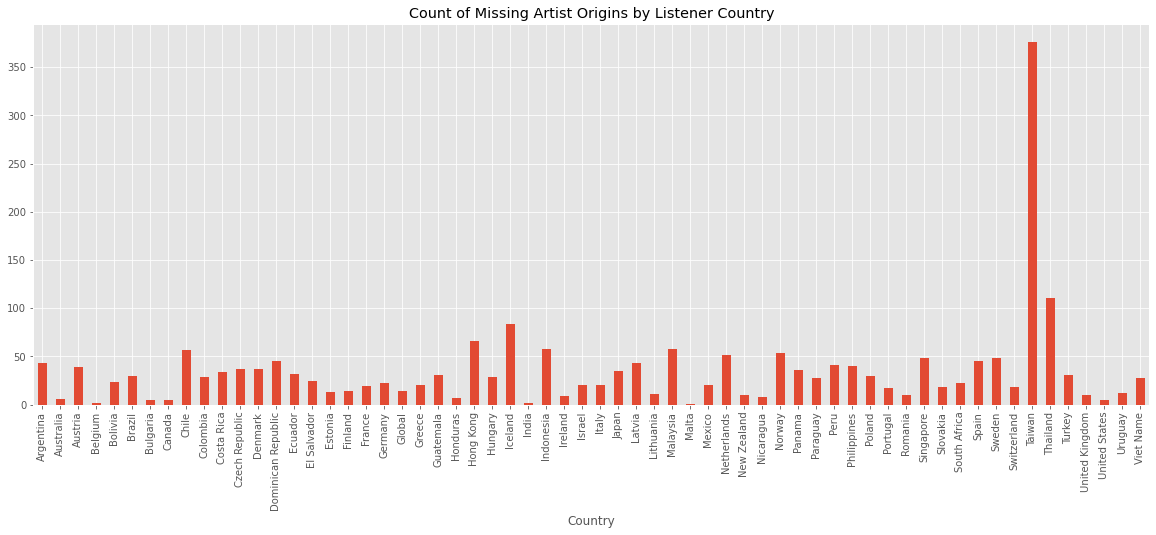

In [51]:
## get distribution of countries with missing artists
plt.figure(figsize = (20, 7))
plt.title('Count of Missing Artist Origins by Listener Country')
missing_art.groupby('Country')['Artist'].nunique().plot(kind = 'bar');

In [52]:
## drop Natls not found and global counts
mask = (df3.Natl != 'not_found') & (df3.Country != 'Global')
df4 = df3[mask]
df4.reset_index(inplace = True, drop = True)
#df4.to_csv('./data/brit-rock-origins-world.csv')

-------

<p float='left'>
    <img src='./images/queen.jpg' width = 320 height = 300/>
    <img src='./images/bowie.jpeg' width = 420 height = 400/>
</p>

### V. Modeling -

Differences notwithstanding, we can all agree on Mozart. This postulate motivates a ***Universal Appeal*** approach to the complex question of which country produces the "greatest" musicians. 

*Universal Appeal* is a metric I've created which assumes the best music transcends borders, connects with listeners more profoundly, and results in a higher relative stream frequency and likelihood of being shared.

The idea for Universal Appeal was driven by the need to simplify, i.e., control for the litany of variables that contribute or diminish a musician's popularity, such as native langauge, country population size, Spotify's relative market penetration, jingoistic tendencies, et cetera. 

Mathematically, Universal Appeal uses a probabilitistic model to represent all variance, theoretically cancelling the aforementioned statistical noise. Conceptually, given the population of all Spotify streams, if `Country X` consistently produces the "best" musicians, then the aggregate likelihood of a listener streaming a `Country X` artist from anywhere in the world will be higher.

Cast in Bayesian terms, the probability of artist, given country, is the probability of country, given artist multiplied by the probability of artist, divided by probability of country to normalize the result:

***\>> P(stream of artist from nation X | listener in country Y) = P(listener in country Y | stream of artist from nation X) * P(stream of artist from nation X) / P(listener in country Y)***

<center><img src='./images/bayes.png' width = 350 height = 250/></center>

In [ ]:
## load saved df - as required
df4 = pd.read_csv('./data/brit-rock-origins-world.csv')
df4.drop(columns = 'Unnamed: 0', inplace = True)
df4.head(3)

##### **5.1 - Streams by Artist Nationality**

The `streams` dataframe was generated to feed downstream calculations, but can also serve as a naive  baseline. Measured by total stream count, American artists have over 3x the streams as \#2 England. However, since Spotify was launched in the US, American artists effectively got a major head start, so it would be hasty to make any conclusions about their relative merit.

In [53]:
## groupby streams
streams = df4.groupby(['Artist', 'Natl'], as_index = False)['Streams'].sum()\
             .sort_values('Streams', ascending = False)\
             .reset_index(drop = True)
streams.head()

,Artist,Natl,Streams
0,Post Malone,American,7812910188
1,Drake,Canadian,6532832744
2,Ed Sheeran,British,6339202275
3,XXXTENTACION,American,4635922585
4,Ariana Grande,American,4167257097


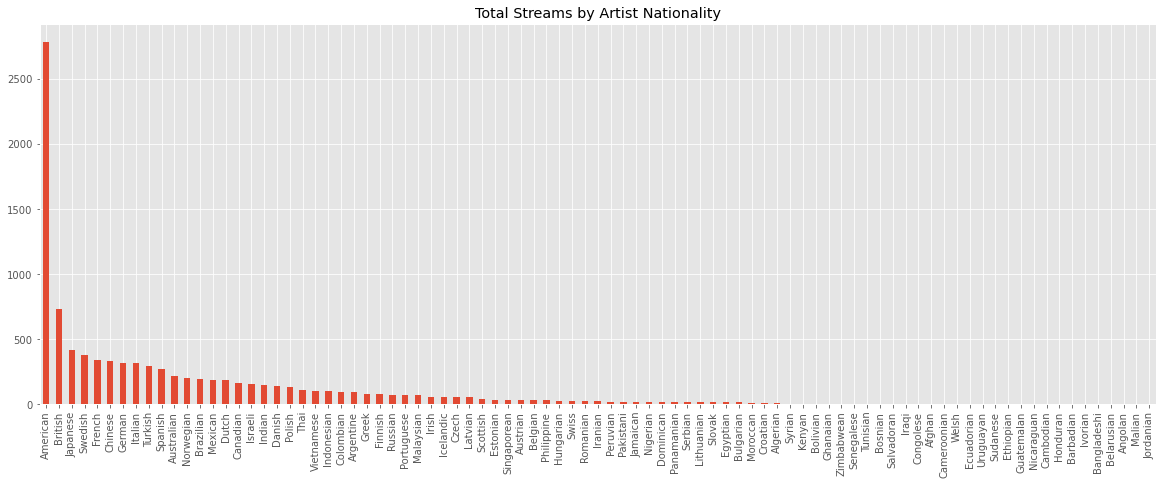

In [54]:
plt.figure(figsize = (20, 7))
plt.title('Total Streams by Artist Nationality')
streams.Natl.value_counts().plot(kind = 'bar');

<p>&nbsp</p>

##### **5.2 - Streams by Country & Nationality:**

Grouping by Country & Nationality, the `natl_streams` dataframe is created to show every permutation for the total number of Streams a given Country listened to of artists with a given national origin. For example, index line 2 tells us how many American artist streams the UK consumed: 8,388,514,917. 
<br><br>


In [55]:
## dataframe of combinations of listener country and artist nationality
natl_streams = df4.groupby(['Country', 'Natl'], as_index = False)['Streams'].sum()\
                  .sort_values('Streams', ascending = False)\
                  .reset_index(drop = True)
natl_streams.head()

,Country,Natl,Streams
0,United States,American,57206031664
1,Brazil,Brazilian,12667798664
2,United Kingdom,American,8388514917
3,Mexico,American,6772444691
4,Canada,American,6314100401


The `natl_streams` dataframe is used to fill the `df_mat` matrix rows for each country. The example below would be for the Country = 'United States' row.

In [56]:
natl_streams.loc[natl_streams.Country == 'United States'].head()

,Country,Natl,Streams
0,United States,American,57206031664
9,United States,Canadian,5445599891
15,United States,British,3700929980
46,United States,German,978192545
58,United States,French,759716027


##### **5.3 - Construct Matrix:**

Since a 1-to-1 relationship exists between each country and the total streams that country consumes of a categorical artist nationality, a relational matrix is a superior representation that will supply the raw values for total streams by country, given nationality for subsequent calculations. 

The `df_mat` dataframe achieves this with artist nationalities as the index and countries as the columns, with total streams for that query in the intersecting cell. We build a function `makeMatrix` that we can use to iteratively build `df_mat`.

In [58]:
## convert above to matrix of country x Natl
idx = natl_streams.Country.unique().tolist()
cols = natl_streams.Natl.unique().tolist()

## define df_mat with artist nationalities as idx and countries as cols
df_mat = pd.DataFrame(columns = cols, index = idx)

def makeMatrix(country, df1, df2):
    '''
    Calculate nationality values for each row (country)
    
    args: country - row value
          df1 - natl_streams
          df2 - df_mat
          
    returns: list of values representing the query for total streams of artist nationality by country
    '''
    
    ## compute total streams for each natl by country - not compliant with PEP-8 char limit of 79...
    streams = [df1.loc[(df1.Country == country) & (df1.Natl == c)]['Streams'].values for c in df2.loc[country].index]
    ## control for empty lists and return results
    return [s[0] if len(s) != 0 else np.NaN for s in streams]

for row, col in df_mat.iterrows():
    df_mat.loc[row] = makeMatrix(row, natl_streams, df_mat)

## transpose axis & replace NaN with zeros 
df_mat = df_mat.T
df_mat.fillna(0, inplace = True)

#df_mat.to_csv('./output/stream-matrix.csv')
df_mat.head()

,United States,Brazil,United Kingdom,Mexico,Canada,Germany,Australia,France,Italy,Spain,...,Finland,India,Estonia,Belgium,Bulgaria,Malta,Uruguay,Honduras,Nicaragua,Luxembourg
American,57206031664,4415155336,8388514917,6772444691,6314100401,5509237572,5457900648,2015965732,2608498759,4351236956,...,19711337,21040739,33914985,25293274,8169588,6941003,6884329,5565750,5543708,3013981
Brazilian,13192026,12667798664,1561530,111111603,1623076,23793734,1100204,18811219,59195409,69438285,...,0,0,131050,0,0,7247,2506,0,9341,0
British,3700929980,1036369838,6165464430,1130959058,754835277,1761079881,1480531301,503753815,654550921,819858591,...,4438867,3508729,8980518,8048819,2352870,3213984,503155,384811,846067,1631099
German,978192545,57045641,86002540,24468890,86747678,5467985646,68644707,168440478,45801147,36079415,...,1648685,0,884956,667831,298615,100032,48445,62227,0,42737
Canadian,5445599891,394861586,1225899208,363153102,977323441,544118557,595936549,185699780,176808134,152149049,...,2848274,4444213,3173750,1997261,941432,867752,168379,98991,250344,459989


<p>&nbsp</p>

##### **5.4 - Normalizing Probability:**

The probability in the denominator of Bayes Theorem `P(B)`, serves to normalize the values and represents the probability of the data. In our approach, this is the independent probability that a song is being streamed in a given country. This intuitively makes sense, because if more songs are being streamed in a given country, it will skew the results unless the weighting is counterbalanced.

Armed with the raw data in a relational format, we can proceed to calculate the "best" according to Bayesian Statistics. We will create 3 dataframes (`prob1`, `prob2`, and `prob3`) to calculate the Norm, Prior, and Likelihood values, respectively. They will ultimately be combined and indexed to calculate the Posterior.

* prob1: P(B) = prob listener in country (Norm)
* prob2: P(A) = prob artist from Natl (Prior)
* prob3: P(B | A) = P(stream of artist from nation X | listener in country Y) (Likelihood)

In [59]:
## prob given stream listener in country
prob1 = df4.groupby('Country', as_index = False)['Streams'].sum()\
           .sort_values('Streams', ascending = False)\
           .reset_index(drop = True)

## sum total streams
tot_str = streams.Streams.sum()

## calc P(B) values
prob1['P(B)'] = prob1.Streams/tot_str

#prob1.to_csv('./output/norm-prob.csv')
prob1.head()

,Country,Streams,P(B)
0,United States,71675051254,0.257511
1,Brazil,20310549149,0.072971
2,United Kingdom,18470739249,0.066361
3,Germany,17617946211,0.063297
4,Mexico,17347144474,0.062324


<p>&nbsp</p>

##### **5.5 - Prior Probability:**

The probability of a given song being streamed by a given nationality in our problem is the *Prior Probability*, denoteed `P(A)`. This probability is independent of the country in which it is being streamed:
> **P(A) = total_streams_by_artists_from_country_X / total_streams_by_all_artists**

In the example below, we find that 10.8% of all songs streamed are written by British artists. The `prob2` dataframe is then built computing the *Priors* for all nationalities.

In [60]:
## sum british streams
tot_brit_str = streams.loc[streams.Natl == 'British']['Streams'].sum()
print(f'Songs streams written by british artists: {tot_brit_str:,}')
print(f'Total songs streamed globally by all artists: {tot_str:,}')

## calc prior probability for artist = British
print('P(british_stream): {0:.5g}%'.format(100*tot_brit_str / tot_str))

Songs streams written by british artists: 28,073,336,232
Total songs streamed globally by all artists: 278,337,842,349
P(british_stream): 10.086%


In [61]:
## prob given stream by artist from Nation
prob2 = df4.groupby('Natl', as_index = False)['Streams'].sum()\
           .sort_values('Streams', ascending = False)\
           .reset_index(drop = True)

prob2['P(A)'] = prob2.Streams/tot_str
#prob2.to_csv('./output/prior-prob.csv')
prob2.head()

,Natl,Streams,P(A)
0,American,137815377945,0.495137
1,British,28073336232,0.100861
2,Brazilian,13396193733,0.048129
3,Canadian,12686717224,0.045580
4,Colombian,10729220528,0.038547


##### **5.6 - Likelihood:**

We now need to calculate the **P(B|A)**, known in Bayesian terms as the **likelihood**. This tells us the following:
<br>
> *What is the probability that a listener is streaming in country B, given the track is by artist of nationality A?*


Example: calculate the probability that a listener is streaming a track in the US, given the artist is American. 

> From the top left corner of the `df_mat` matrix, we find the total streams listened to in the US by American artists is = 57,206,031,664, which we'll define `us_str_of_amr`. We then use the previously calculated total streams for American artists in the `prob2` table of 137,815,377,945, defined as `amr_str`. Thus, the likelihood that a listener is streaming in the US, given the track is by an artist is of American origin, is `us_str_of_amr / amr_str` = 41.509%. We then generate a table for every permutation of artist origin and listener country.

*\>> This dataframe will supply the **Baysian Likelihood** values for our calculations: P(Natl | Country)*

In [62]:
## copy total values df_mat to use raw values
likelihood = df_mat.copy()
## transpose df to iterate over columns
likelihood = likelihood.T

## iterate over columns
for col in likelihood.columns:
    ## divide streams in given country of artist nationality by total streams of artist nationality
    likelihood[col] = likelihood[col]/prob2.loc[(prob2.Natl == col)]['Streams'].values[0]
    
## save and preview
#likelihood.to_csv('./output/likelihood.csv')
likelihood.head()

,American,Brazilian,British,German,Canadian,French,Italian,Colombian,Mexican,Dutch,...,Belarusian,Ecuadorian,Ethiopian,Ivorian,Cambodian,Honduran,Zimbabwean,Nicaraguan,Guatemalan,Jordanian
United States,0.415092,0.000985,0.131831,0.119579,0.429236,0.080479,0.004249,0.022676,0.002847,0.069905,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brazil,0.032037,0.945627,0.036917,0.006974,0.031124,0.018531,0.001504,0.013094,0.001778,0.021808,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
United Kingdom,0.060868,0.000117,0.219620,0.010513,0.096629,0.038592,0.008535,0.004319,0.000687,0.030759,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mexico,0.049141,0.008294,0.040286,0.002991,0.028625,0.028870,0.002931,0.303839,0.684052,0.019092,...,0.0,0.995877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Canada,0.045816,0.000121,0.026888,0.010604,0.077035,0.016807,0.000826,0.003007,0.000320,0.017663,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### **5.7 - Posterior Probability:**

Having computed all other values required for Bayes Theorem, we can calculate the **Posterior Probability: P(A|B)**
<br>
> *What is the probability that a track is by an artist of nationality A, given the listener is in country B?*

A Bayesian approach was chosen with the assumption that if some countries are truly over-represented on their production of gifted musicians, then we will observe a global preference for their work. It allows us individually consider each listener country's artistic preferences while overlaying the relative consumption of artist nationalites to compare a country across the globe. Since all inputs are probabilities, we control for population and other distortions. When we average the posterior probabilities for every country, we essential cancel out the depency bias on country. 

> This yields a measure for, **"all things being equal, for which artist nationality does the world exhibit a preference?"**

We first calculate the posterior probabilities for each country in the matrix and then compute the mean. We check our math by manually calculating the first cell's value: United States & American:

1. From the `prob1` dataframe with normalizing probability, we know the total streams in the US are `us_str` = 71,675,051,254. 
2. In the top left corner of the `df_mat` matrix, we find the total streams listened to in the US by American artists is `us_str_of_amr` = 57,206,031,664. 
3. We confirm in the `posterior` dataframe of an artist is of American origin, given the listener is streaming in the US, is `us_str_of_amr / us_str` = 79.81%.

In [63]:
def calc_Bayesian(natl, df1, df2, df3):
    '''
    natl - row
    df1 - prob1
    df2 - prob2
    df3 - likelihood
    '''
    norm = [df1.loc[df1.Country == c]['P(B)'].values[0] for c in df3.loc[natl].index]
    prior = df2.loc[(df2.Natl == natl)]['P(A)'].values[0]
    likely = df3.loc[natl].values
    ## calculate posterior probability
    post = prior*likely/norm
    return post

posterior = likelihood.T.copy()

for row, col in posterior.iterrows():
    posterior.loc[row] = calc_Bayesian(row, prob1, prob2, posterior)

#posterior.to_csv('./output/posterior.csv')
posterior.head()

,United States,Brazil,United Kingdom,Mexico,Canada,Germany,Australia,France,Italy,Spain,...,Finland,India,Estonia,Belgium,Bulgaria,Malta,Uruguay,Honduras,Nicaragua,Luxembourg
American,0.798130,0.217382,0.454152,0.390407,0.700501,0.312706,0.577355,0.207360,0.260734,0.403274,...,0.252828,0.281823,0.527140,0.396888,0.527099,0.500765,0.391570,0.545474,0.536007,0.452877
Brazilian,0.000184,0.623705,0.000085,0.006405,0.000180,0.001351,0.000116,0.001935,0.005917,0.006436,...,0.000000,0.000000,0.002037,0.000000,0.000000,0.000523,0.000143,0.000000,0.000903,0.000000
British,0.051635,0.051026,0.333796,0.065196,0.083743,0.099959,0.156616,0.051816,0.065426,0.075985,...,0.056935,0.046996,0.139584,0.126297,0.151806,0.231876,0.028619,0.037714,0.081804,0.245087
German,0.013648,0.002809,0.004656,0.001411,0.009624,0.310365,0.007261,0.017326,0.004578,0.003344,...,0.021147,0.000000,0.013755,0.010479,0.019267,0.007217,0.002755,0.006099,0.000000,0.006422
Canadian,0.075976,0.019441,0.066370,0.020934,0.108427,0.030884,0.063040,0.019101,0.017673,0.014101,...,0.036533,0.059526,0.049330,0.031340,0.060741,0.062605,0.009577,0.009702,0.024205,0.069117


In [64]:
## test all vals sum to 1
def test(val):
    assert round(val, 1) == 1.0
    
_ = [test(posterior[c].sum()) for c in posterior.columns]

Calculate mean posterior probability:

          Posterior
American   0.451638
British    0.114056
Colombian  0.060013
Canadian   0.038249
French     0.029477


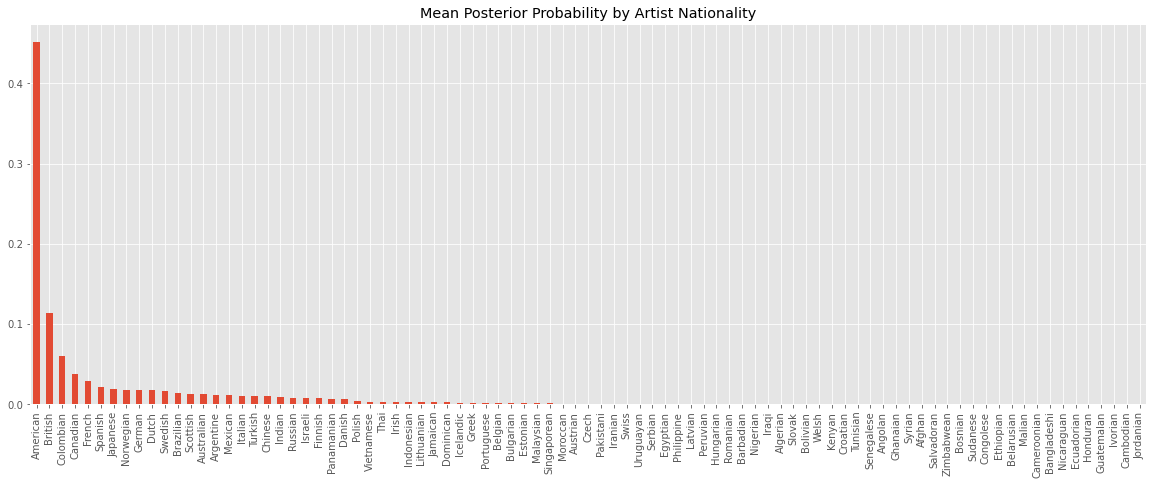

In [65]:
art_mean = pd.DataFrame(index = natl_streams.Natl.unique().tolist(), columns = ['Posterior'])

for row, col in art_mean.iterrows():
    art_mean.loc[row, 'Posterior'] = posterior.loc[row].mean()

art_mean.sort_values(by = 'Posterior', ascending = False, inplace = True)
#art_mean.to_csv('./output/art-mean.csv')
print(art_mean.head())

## plot results
plt.figure(figsize = (20, 7))
plt.title('Mean Posterior Probability by Artist Nationality')
art_mean['Posterior'].plot(kind = 'bar');

--------


### VI. Analysis & Visualization -

* With the \#1 position in 54 of the 62 countries, the US was by far the global preference for artist origin from 2017-01-01 to 2019-07-01 according to this dataset.

* British and Columbians are second favorites across 24 and 15 countries, respectively.

* A strong preferences exists for local artists.

***\>> [Link to Tableau dashboard for this project]('https://public.tableau.com/app/profile/russell.w.myers/viz/WhatsintheWater/Dashboard1')***

**6.1 - Discussion**

Although I expected the results to be less skewed American, they are also somewhat more balanced than expected across 3 visual tiers, denoted with black vertical lines below. 

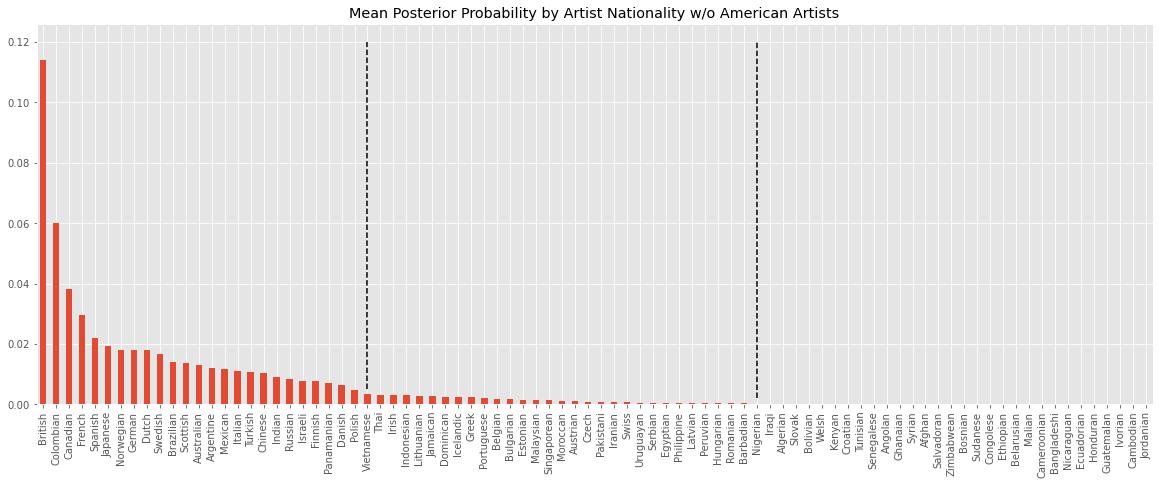

In [68]:
## drop American Artists
am2 = art_mean.drop(['American'])

## plot results
plt.figure(figsize = (20, 7))
plt.title('Mean Posterior Probability by Artist Nationality w/o American Artists')
plt.vlines(x = 25, ymin = 0.005, ymax = 0.12, linestyles = 'dashed', colors = 'black')
plt.vlines(x = 55, ymin = 0.002, ymax = 0.12, linestyles = 'dashed', colors = 'black')
am2['Posterior'].plot(kind = 'bar');

<p>&nbsp</p>

It's been mentioned that given Spotify's heritage, American artists were earliest to the platform. There may also be other contributing factors, but after calculating the American posterior to be 9x the standard deviation, it makes sense to consider it an outlier and drop it before evaluating the results. Dropping Americans reduces the posterior standard deviation from 0.05 to 0.015.

> ##### ***"If you torture the data long enough, it will tell you whatever you want to hear."***

Subsequent to removing the American outlier, British artists become the clear global favorite. Admittedly, it would seem I've been "data dredging" or "p-hacking" to support my hypothesis... 

In my defense, I could not have known the British would be occupying the \#2 slot. Further, of the top 15 British artists below, Queen is the only band whose music I know - and quite well. This latter point actually further supports my hypothesis: although listeners skew younger, the new crop of British musicians are very popular on their own - without material help from the Beatles, Stones, Led Zeppelin, Pink Floyd, or Radiohead. 

In [69]:
## top 15 British artists by streams
streams.loc[streams.Natl == 'British'].sort_values(by = 'Streams', ascending = False).head(15)

,Artist,Natl,Streams
2,Ed Sheeran,British,6339202275
19,Dua Lipa,British,1888830618
26,Clean Bandit,British,1667356118
35,Sam Smith,British,1317122871
38,ZAYN,British,1250436533
53,Queen,British,1056667740
54,Jonas Blue,British,1043714475
66,James Arthur,British,922647182
80,Liam Payne,British,714242649
88,Rita Ora,British,652519298


**6.2 - National Preference?**

Even in an increasingly globalized world, it seems logical that artists would be more popular in their native countries. In a perfect world, musicians typically tour locally to promote their sound, which leads to a record deal, which funds professional promotion and international touring. There are many exceptions (the talents of Jimi Hendrix and Bob Dillon were first recognized in England). 

We will again drop the US and see whether this preference is recognizable in the numbers.
<br><br>

In [ ]:
## import / prep data
posterior = pd.read_csv('./output/posterior.csv')
posterior.rename(columns = {'Unnamed: 0': 'Country'}, inplace = True)
posterior.index = posterior.Country.unique().tolist()
posterior.drop(columns = 'Country', inplace = True)

In [70]:
## remove the US outlier from posterior
tops = posterior.drop('American')
## create a dataframe referencing the index of the maximum posterior in each column
tops = pd.DataFrame(tops.idxmax(), columns = ['Artist-Natl'])
## preview result
tops.head()

,Artist-Natl
United States,Canadian
Brazil,Brazilian
United Kingdom,British
Mexico,Colombian
Canada,Canadian


In [ ]:
## import dfc
dfc = pd.read_csv('./data/countries.csv')

In [71]:
## dict to map countries to adjectives
mapC2A = dict(zip(dfc.Country, dfc.Adjective))

## reset index and rename column
tops.reset_index(inplace = True)
tops.rename(columns = {'index':'Country'}, inplace = True)

## create a 'pref' column to determine whether the country favors its own musicians
tops['pref'] = tops.apply(lambda x: x['Artist-Natl'] == mapC2A.get(x['Country'], np.NaN), axis = 1)
tops.head()

,Country,Artist-Natl,pref
0,United States,Canadian,False
1,Brazil,Brazilian,True
2,United Kingdom,British,True
3,Mexico,Colombian,False
4,Canada,Canadian,True


With the US out of the running, we find that 30.65% of countries prefer homegrown artists. 

In [72]:
## percentage of countries that favor their own if not the US
tops.loc[tops.pref == True].shape[0]/tops.shape[0]

0.3064516129032258

<p>&nbsp</p>

**6.3 - Audiophiles:**

To determine which countries love music the most (in Spotify format), we bring in country population data. With Norway, Sweden, and Iceland consuming the most Streams Per Capita, it seems a correlation may exists between latitude and audiophiles.

In [73]:
## country pop
dfp = pd.read_csv('./data/populations-by-country.csv')

## slice essential fields
dfp = dfp[['Country', 'Population']]

## convert population strings to int
dfp.Population = dfp.Population.str.replace(',', '').astype(int)
dfp.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [74]:
df5 = df4.groupby('Country', as_index = False)['Streams'].sum()\
                  .sort_values('Streams', ascending = False)\
                  .reset_index(drop = True)

## merge country population data
df5 = pd.merge(df5, dfp)

## compute and sort by streams per capita
df5['StrPerCap'] = df5.Streams / df5.Population
df5 = df5.sort_values('StrPerCap', ascending = False).reset_index(drop = True)

#df5.to_csv('./output/str-per-cap.csv')
df5.head()

,Country,Streams,Population,StrPerCap
0,Norway,4605025440,5421241,849.441196
1,Sweden,7758058748,10099265,768.180531
2,Iceland,205842430,341243,603.213634
3,Netherlands,9165316741,17134872,534.892630
4,Denmark,2449818898,5792202,422.951219


Plot of streams per capita by country - 

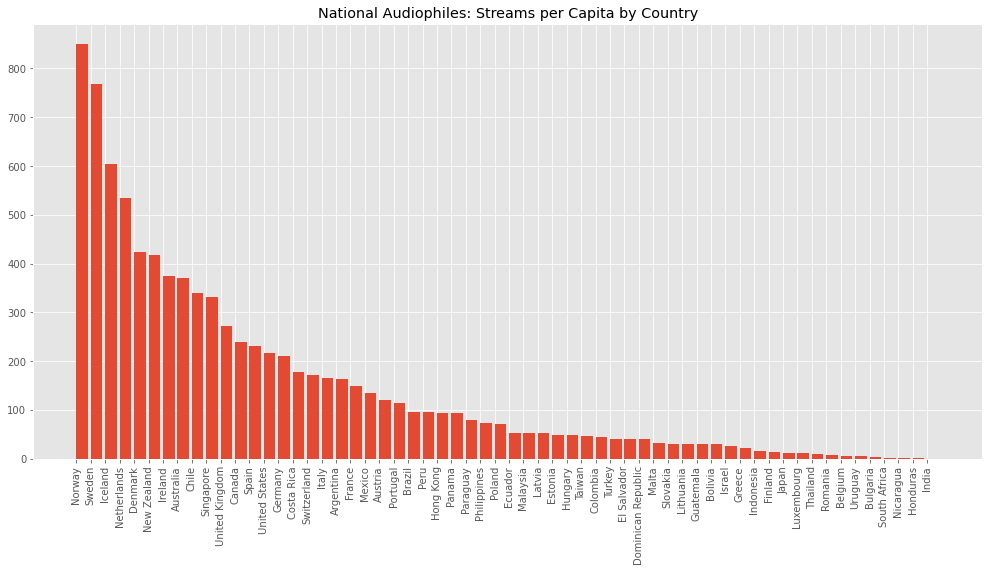

In [76]:
plt.figure(figsize = (17, 8))
plt.title('National Audiophiles: Streams per Capita by Country')
plt.bar(df5.Country, 
        df5.StrPerCap, 
        align = 'edge')
plt.xticks(rotation='vertical');

<p>&nbsp</p>

**6.4 - Musical GDP:**

As the analog to which countries consume the most music per capita, we now want to determine which countries yield the greatest musical output. Artist Per Capita is a measure of many streams are consumed by artists from a given nation, normalized for that nation's population. 

As is often the case with smaller samples, we find that Barbados, with a population of X, has the highest musical GDP - note: Rihanna is from Barbados. 

In [77]:
## build df of streams by Artist Natl
df6 = df4.groupby('Natl', as_index = False)['Streams'].sum()\
         .sort_values('Streams', ascending = False)\
         .reset_index(drop = True)

## build dict to map artist natl to country and map values
mapA2C = dict(zip(mapC2A.values(), mapC2A.keys()))
df6['Country'] = df6.Natl.apply(lambda x: mapA2C.get(x, np.NaN))

## merge country population data
df6 = pd.merge(df6, dfp)

## Streams produced by Natl per population
df6['ArtPerCap'] = df6.Streams/df6.Population
df6.head()

## merge country population data
df6 = pd.merge(df6, dfp)

#df6.to_csv('./output/art-per-cap.csv')
df6.head()

,Natl,Streams,Country,Population,ArtPerCap
0,American,137815377945,United States,331002651,416.357324
1,British,28073336232,United Kingdom,67886011,413.536395
2,Brazilian,13396193733,Brazil,212559417,63.023290
3,Canadian,12686717224,Canada,37742154,336.141844
4,Colombian,10729220528,Colombia,50882891,210.861064


Plot of streams produced by nationality per capita -

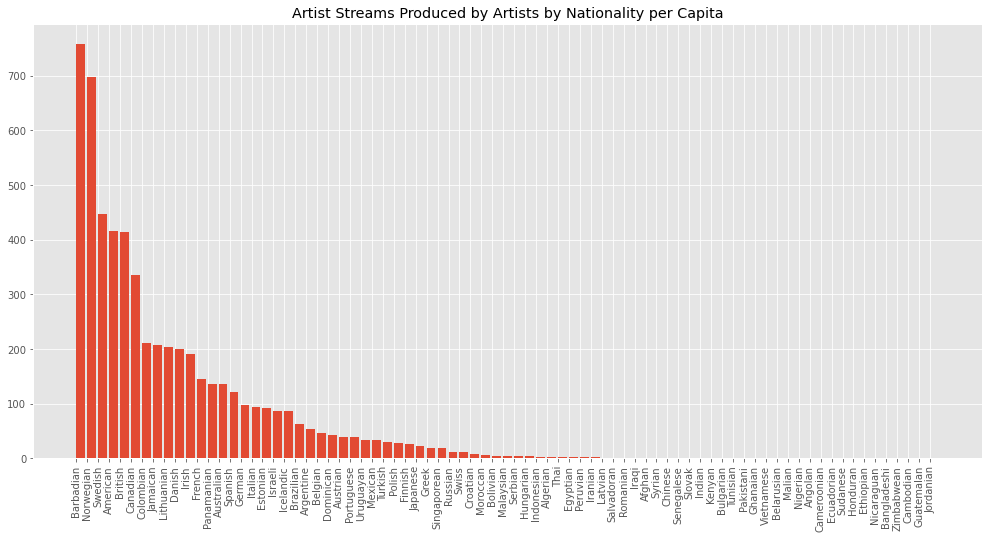

In [78]:
df6.sort_values(by = 'ArtPerCap', 
                inplace = True,
                ascending = False)

plt.figure(figsize = (17, 8))
plt.title('Artist Streams Produced by Artists by Nationality per Capita')
plt.bar(df6.Natl, 
        df6['ArtPerCap'], 
        align = 'edge')
plt.xticks(rotation='vertical');

**6.5 - Musical Industriousness:**

To account for the small nation problem, another approach to the question of which nations have the greatest musical output is to measure trends vice extremes. To quantify this, we group by the unique artists from each country with songs in the Top 200, and normalize by population.

Perhaps not surprisingly, we again find that Scandinavian countries are decidedly the most prolific. More notably, Icelandic artists have an output rate of 3x runnerup Norwegians. 

In [79]:
df7 = df4.groupby('Natl')['Artist'].unique()\
         .apply(lambda x: len(x))\
         .rename('Uniq-Art').reset_index()

## sort values by unique artists
df7 = df7.sort_values('Uniq-Art', ascending = False).reset_index(drop = True)
## preview to verify merge
df7.head()

,Natl,Uniq-Art
0,American,2785
1,British,733
2,Japanese,419
3,Swedish,380
4,French,343


In [80]:
df8 = pd.merge(df6, df7)
df8.head()

,Natl,Streams,Country,Population,ArtPerCap,Uniq-Art
0,Barbadian,217698920,Barbados,287375,757.543001,1
1,Norwegian,3783054121,Norway,5421241,697.820687,204
2,Swedish,4522221050,Sweden,10099265,447.777244,380
3,American,137815377945,United States,331002651,416.357324,2785
4,British,28073336232,United Kingdom,67886011,413.536395,733


Plot of unique artists by nationality - 

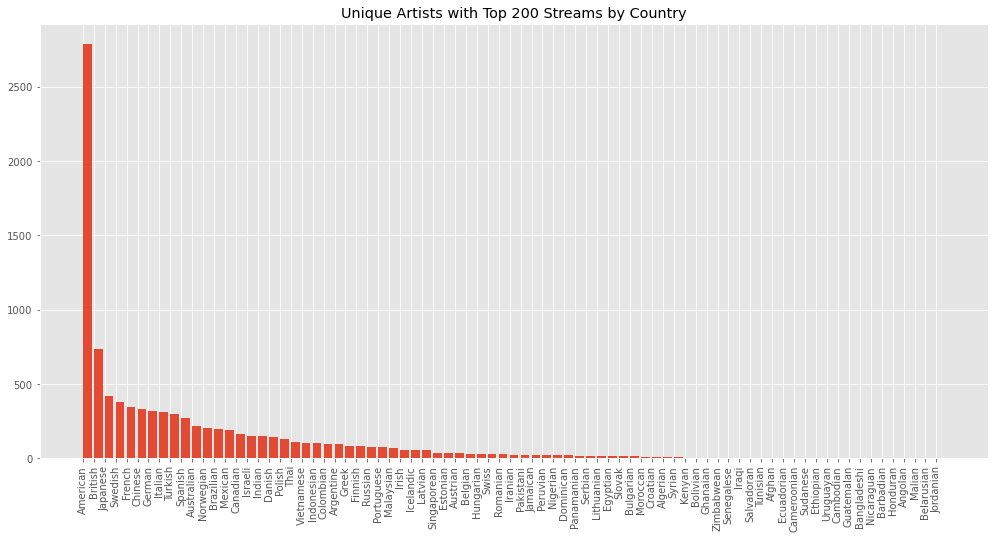

In [81]:
df8.sort_values('Uniq-Art', ascending = False, inplace = True)
plt.figure(figsize = (17, 8))
plt.title('Unique Artists with Top 200 Streams by Country')
plt.bar(df8.Natl, 
        df8['Uniq-Art'], 
        align = 'edge')
plt.xticks(rotation='vertical');

Plot of Unique Artists with Top 200 Streams by Normalized Population Nationality - 

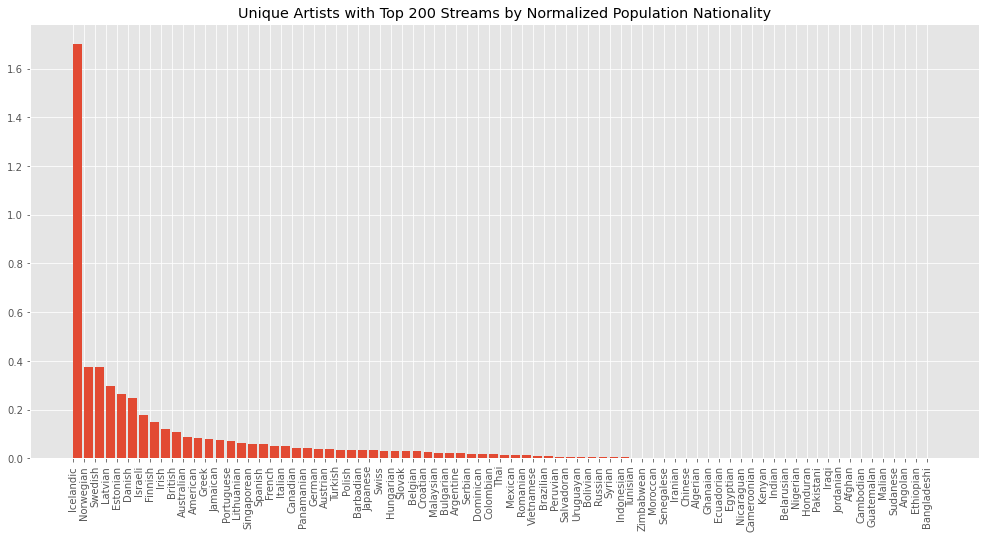

In [82]:
## normalize unique artist
df8['UniqArtPerCap'] = 10000*df8['Uniq-Art']/df8.Population
df8.sort_values('UniqArtPerCap', ascending = False, inplace = True)
#df8.to_csv('./output/uniq-art-per-cap.csv')

## unique artists by nationality
plt.figure(figsize = (17, 8))
plt.title('Unique Artists with Top 200 Streams by Normalized Population Nationality')
plt.bar(df8.Natl, 
        df8['UniqArtPerCap'], 
        align = 'edge')
plt.xticks(rotation='vertical');

**6.6 - Future Work:**

Our conclusions about musicians and nationalities for this project were bound by the Spotify user population and the time period. From a consumption perspective, this approach is problematic not only because it excludes those without access to smart phones, but also excludes all music deliberately played by all people on the planet over the same period.

To make our conclusions more robust, we could first attempt to source a wider date range of Spotify listener data. Additionally, since these data only cover artists who made the Top 200 in a given day, acquiring all material streams would account for tracks that burn low and slow. In addition to Spotify, we could merge data from other streaming music platforms, such as Apple Music, Amazon Music, YouTube Music, and Pandora. Finally, we would account for the access problem by scaling the streams of each country by the inverse percentage of the population with smart phones.

Even if we had perfect streaming data, it would only account for music in the modern era. A logical solution would be to segment eras by the dominant technology and compare the relative numbers. For example, radio broadcasts, record sales, tape sales, CD sales, and iTunes downloads were the top form of distribution during distinct periods. Although many still purchase records, it is a fractional market share relative to streaming platforms. But if you wanted learn about the music scene in the 50's, the answer is in the vinyl. 